In [174]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
import uncertainties as unc
import os

T2 = 1.2196±0.0009s


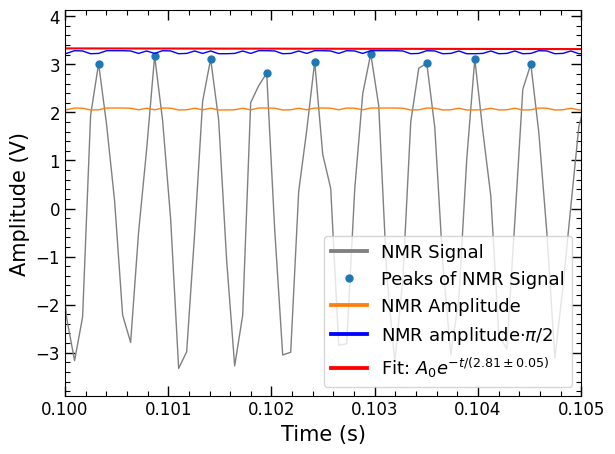

T2 = 1.214±0.004s


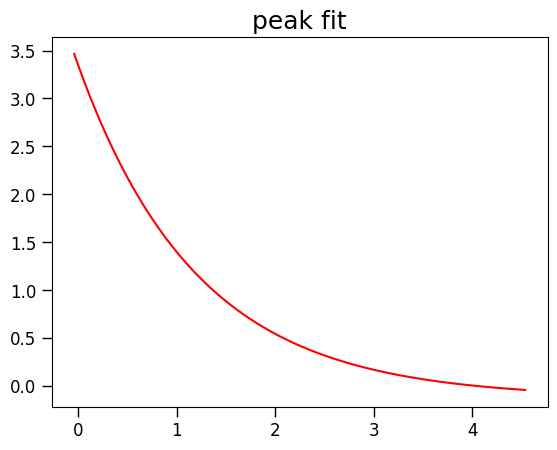

In [ ]:
class NMR_data:
    def __init__(self, filepath, cutoff_below=None):
        """cutoff: load data only after the first value above the cutoff"""

        self.file = filepath
        df = pd.read_csv(filepath, skiprows=[1])
        df = df.replace([np.inf, -np.inf, np.nan], 0) # remove these cus the curve_fit doesn't like them

        self.raw_df = df

        if cutoff_below:
            start_index = df[df['4'] > cutoff_below].index[0]
            df_filtered = df.iloc[start_index:]
            df_filtered = df_filtered.reset_index(drop=True)
            self.df = df_filtered
        else:
            self.df = df

        self.time = self.df["x-axis"] # s
        self.signal = self.df["2"] # V
        self.amplitude = self.df["4"] # V

        self.raw_time = self.raw_df["x-axis"] # s
        self.raw_signal = self.raw_df["2"]
        self.raw_amplitude = self.raw_df["4"]

def t2_function(t, A, B, T2):
    return A * np.exp(-t/T2) + B

def find_signal_peaks(data):
    peaks, _ = find_peaks(data.signal.values)
    peak_times = data.time.values[peaks]
    peak_magnitudes = data.signal[peaks]
    return peak_times, peak_magnitudes

data1 = NMR_data(r"C:\Users\nagyk\OneDrive\2425.1b\Lab4 - NMR\data & processing NMR\raw osc data\nmr-pt4-cv29.91v.csv", 
cutoff_below=2)
peak_times, peak_magnitudes = find_signal_peaks(data1)

# plt.plot(data1.time, data1.signal, label='NMR Signal', linewidth=0.1, color="gray")
# plt.plot(peak_times, peak_magnitudes, "o", label='Peaks of NMR Signal', markersize=2)
# plt.plot(data1.time, data1.amplitude, label='NMR Amplitude', linewidth=0.1)
# plt.plot(data1.time, data1.amplitude*(np.pi/2), label=r'NMR amplitude$\cdot \pi/2$', linewidth=0.2, color="blue")

plt.plot(data1.raw_time, data1.raw_signal, label='NMR Signal', linewidth=1, color="gray")
plt.plot(peak_times, peak_magnitudes, "o", label='Peaks of NMR Signal', markersize=5)
plt.plot(data1.raw_time, data1.raw_amplitude, label='NMR Amplitude', linewidth=1)
plt.plot(data1.raw_time, data1.raw_amplitude*(np.pi/2), 
         label=r'NMR amplitude$\cdot \pi/2$', linewidth=1, color="blue")


# Add labels and title
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (V)')

# plt.xlim(0.1, 0.11)

# Show the plot
# plt.xlim(0.2, 0.2075)
# plt.savefig("exp4-t2-lines explained.png", dpi=my_dpi)

# plt.ylim(0)
# plt.show()


def t2_fit(data=None, xy=None, show=True):
    if xy:
        x, y = xy
        linestyle='None'
    else:
        x, y = data.time, data.amplitude
        y *= np.pi/2
        linestyle='-'
    popt, pcov = curve_fit(t2_function, x, y, p0=[np.max(y), 0, 1])
    if show:
        # plt.plot(x, y, label='data', marker='.', linestyle=linestyle, markersize=1)    
        plt.plot(x, t2_function(x, *popt), linewidth=1.5, color='red',
                 label=r"Fit: $A_0e^{-t/"+ f"({T1:.1uL})" + r"}$")

    t2 = unc.correlated_values(popt, pcov)[2]
    return t2


print(f"T2 = {t2_fit(data=data1):.1uP}s")
# plt.title('amp fit')
legend = plt.legend(markerscale=1, loc='lower right', fontsize=13)
for line in legend.get_lines():
    line.set_linewidth(2.75)
plt.tick_params(axis='both', which='both', direction='in', top=True, right=True)
plt.minorticks_on()
# plt.savefig("exp4-t2-main.png", dpi=300)
# plt.savefig("exp4-t2-apx-full.png", dpi=300)
plt.xlim(0.1, 0.105)
plt.tight_layout()
# plt.savefig("exp4-t2-apx-zoomed.png", dpi=300)
plt.show()
print(f"T2 = {t2_fit(xy=[peak_times, peak_magnitudes]):.1uP}s")
plt.title('peak fit')
plt.show()

In [181]:
def analyze_nmr_data(file_path, cutoff_below=2, show=True):
    """
    Analyze NMR data from a file, plot signals and fits, and calculate T2 values.
    
    Parameters:
    file_path (str): Path to the NMR data file
    cutoff_below (float): Cutoff value for data processing
    
    Returns:
    tuple: (T2_continuous, T2_peaks) - T2 values from continuous and peak fits
    """
    # Load and process data
    data = NMR_data(file_path, cutoff_below=cutoff_below)
    peak_times, peak_magnitudes = find_signal_peaks(data)
    
    t2_amp = t2_fit(data=data, show=show)

    t2_peaks = t2_fit(xy=[peak_times, peak_magnitudes], show=show)


    if show:
        # First plot: Signal and amplitude with peaks
        plt.plot(data.time, data.signal, label='NMR signal')
        plt.plot(data.time, data.amplitude, label='NMR amplitude')
    
        plt.plot(peak_times, peak_magnitudes, "x", label='Peaks')
        
        plt.xlabel('Time (s)')
        plt.ylabel('Voltage (V)')
        plt.legend()
        plt.xlim(0.1, 0.11)
        plt.show()
    
        # Second plot: Continuous amplitude fit
        print(f"T2 (amplitudes) = {t2_amp:.1uP}s")
        plt.title('Amplitude fit')
        plt.show()
        
        # Third plot: Peak fit
        print(f"T2 (peaks) = {t2_peaks:.1uP}s")
        plt.title('Peak fit')
        plt.show()
        
    return t2_amp, t2_peaks


dir_path = r"C:\Users\nagyk\OneDrive\2425.1b\Lab4 - NMR\data & processing NMR\raw osc data"
csv_files = [f for f in os.listdir(dir_path) if f.endswith('.csv')]
t2s_amp, t2s_peaks = [], []
for file in csv_files:
    full_path = os.path.join(dir_path, file)
    t2_amp, t2_peaks = analyze_nmr_data(full_path,
                    cutoff_below=2,
                    show=False)
    print(f"""File: {file}
          T2 (amplitude): {t2_amp:.1uP}s, 
          T2 (peaks): {t2_peaks:.1uP}s
          
          """)

File: nmr-pt4-cv29.91V-v2.csv
          T2 (amplitude): 1.2808±0.0009s, 
          T2 (peaks): 1.283±0.004s
          
          
File: nmr-pt4-cv29.91V-v3.csv
          T2 (amplitude): 1.2706±0.0009s, 
          T2 (peaks): 1.274±0.004s
          
          
File: nmr-pt4-cv29.91V-v6.csv
          T2 (amplitude): 1.4264±0.0008s, 
          T2 (peaks): 1.414±0.005s
          
          
File: nmr-pt4-cv29.91v.csv
          T2 (amplitude): 1.2196±0.0009s, 
          T2 (peaks): 1.214±0.004s
          
          


# exp1: B

In [191]:
import pandas as pd
import numpy as np
from uncertainties import ufloat, unumpy
from uncertainties.umath import sqrt

# Read CSV file
df1 = pd.read_csv(r'C:\Users\nagyk\OneDrive\2425.1b\Lab4 - NMR\data & processing NMR\csv exports\exp1.csv')

# Group measurements by location and calculate statistics for each
location_results = []
latex_table = r"""\begin{table}[tb]
\centering
\begin{tabular}{c|c}
Sample Location (s) & f (kHz) \\ 
\hline \hline"""


for location in sorted(df1['location in the decay (s)'].unique()):
    # Get all frequency measurements for this location
    values = df1[df1['location in the decay (s)'] == location]['f (kHz)']
    
    # Calculate mean and standard error of the mean
    mean = np.mean(values)
    std_err = np.std(values, ddof=1) / sqrt(len(values))  # ddof=1 for sample standard deviation
    
    # Create uncertainty object and store result
    location_results.append(out := ufloat(mean, std_err))
    print(f"Location {location}s: {out:.1uP} kHz")
    latex_table += f"\n{location} & {out:.1uL} \\\\\n\\hline\n".replace(r'\pm', r"$\pm$")

# Calculate weighted average across all locations
final_result = sum(location_results) / len(location_results)
print(f"\nf_final = {final_result:.1uP} kHz")
print(f"f_final = ${final_result:.1uL}$ kHz")
B_final = final_result*1e3*(2*np.pi)/2.675e8
print(f"B_final = {B_final:.1uP} T")
print(f"B_final = ${B_final:.1uL}$ T")
print()


latex_table += r"""\end{tabular}
\caption{Results of the 3 measurements taken at each location along the y-axis for the first experiment. Combining these gave the final result of """ + f"{final_result:.1uL}".replace(r'\pm', r"$\pm$") + """ kHz.}
\label{tab:exp1-B}
\end{table}"""

print(latex_table)


Location 0.054s: 1.922±0.004 kHz
Location 0.527s: 1.926±0.002 kHz
Location 1.17s: 1.922±0.003 kHz
Location 2.22s: 1.923±0.009 kHz

f_final = 1.923±0.003 kHz
f_final = $1.923 \pm 0.003$ kHz
B_final = (4.517±0.006)×10⁻⁵ T
B_final = $\left(4.517 \pm 0.006\right) \times 10^{-5}$ T

\begin{table}[tb]
\centering
\begin{tabular}{c|c}
Sample Location (s) & f (kHz) \\ 
\hline \hline
0.054 & 1.922 $\pm$ 0.004 \\
\hline

0.527 & 1.926 $\pm$ 0.002 \\
\hline

1.17 & 1.922 $\pm$ 0.003 \\
\hline

2.22 & 1.923 $\pm$ 0.009 \\
\hline
\end{tabular}
\caption{Results of the 3 measurements taken at each location along the y-axis for the first experiment. Combining these gave the final result of 1.923 $\pm$ 0.003 kHz.}
\label{tab:exp1-B}
\end{table}


# Exp2 - T1

In [183]:
plt.rc('xtick.major', size=7.5, width=1)   # For x-axis ticks
plt.rc('ytick.major', size=7.5, width=1)   # For y-axis ticks
plt.rc('xtick.minor', size=3.5, width = 0.8)  # For minor x-axis ticks
plt.rc('ytick.minor', size=3.5, width = 0.8)  # For minor y-axis ticks

plt.rcParams['font.size'] = 15  # Base font size
plt.rcParams['xtick.labelsize'] = 12  # X-axis tick labels
plt.rcParams['ytick.labelsize'] = 12  # Y-axis tick labels
plt.rcParams['legend.fontsize'] = 16  # Legend font size
my_dpi = 350

T1 = 2.81±0.05 s
T1 = 2.81 $\pm$ 0.05 s


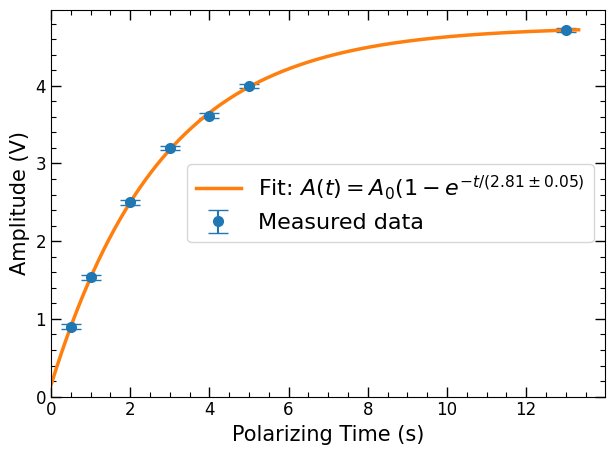

In [204]:
df2 = pd.read_csv(r'C:\Users\nagyk\OneDrive\2425.1b\Lab4 - NMR\data & processing NMR\csv exports\exp2.csv')

t_list = []
A_list = []
A_err_list = []
for time in sorted(df2['polarizing time (s) +/- 0.1s'].unique()):
    # Get all amplitude measurements for this polarization time
    values = df2[df2['polarizing time (s) +/- 0.1s'] == time]['amplitude (x2) (V)']
    values = values / 2 # Divide by 2 to get the actual amplitude

    mean = np.mean(values)
    # not using std cus 
    #! here the oscilloscope error seemed to be more significant, as it showed only 0.1V steps
    osc_err = 0.1/2 #V  The the oscilloscope was showing amplitude in steps 0.1V
    std_err = osc_err / sqrt(len(values)) 

    t_list.append(time)
    A_list.append(mean)
    A_err_list.append(std_err)

# Convert lists to numpy arrays for fitting
t_array = np.array(t_list)
A_array = np.array(A_list)
A_err_array = np.array(A_err_list)

plt.errorbar(t_array, A_array, yerr=A_err_array, fmt='o', 
             capsize=7, markersize=7,
             label='Measured data')
plt.xlabel('Polarizing Time (s)')
plt.ylabel('Amplitude (V)')

def t1_function(t, A, B, T1):
    return A * (1 - np.exp(-t/T1)) + B

popt, pcov = curve_fit(t1_function, t_array, A_array, 
                       sigma=A_err_array, 
                       p0=[np.max(A_array), 0, 3])
T1 = unc.correlated_values(popt, pcov)[2]
print(f"T1 = {T1:.1uP} s")
print(f"T1 = {T1:.1uL} s".replace(r'\pm', r"$\pm$"))

t_test = np.linspace(0, np.max(t_array)*1.025, 500)
plt.plot(t_test, t1_function(t_test, *popt), 
         label=r'Fit: $A(t)=A_0(1-e^{-t/' + f"({T1:.1uL})" + r'}$',
         linewidth=2.5)

plt.legend(loc="center right")
plt.xlim(0)
plt.ylim(0)
plt.tick_params(axis='both', which='both', direction='in', top=True, right=True)
plt.minorticks_on()
plt.tight_layout()
plt.savefig('exp2_t1_fit.png', dpi=my_dpi)
plt.show()


# exp3: Currie

Linear coefficient = 1.54±0.02
Linear coefficient = 1.54 $\pm$ 0.02


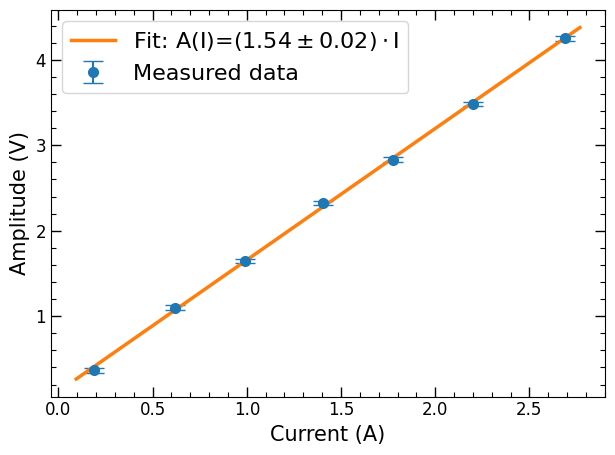

In [205]:
df3 = pd.read_csv(r'C:\Users\nagyk\OneDrive\2425.1b\Lab4 - NMR\data & processing NMR\csv exports\exp3.csv')

I_list = []
A_list = []
A_err_list = []

for current in sorted(df3['current (A) +/-0.001'].unique()):
    # Get all amplitude measurements for this current
    values = df3[df3['current (A) +/-0.001'] == current]['amplitude (x2) (V) +/-0.1']
    values = values / 2 # Divide by 2 to get the actual amplitude

    mean = np.mean(values)
    # not using std cus 
    #! here the oscilloscope error seemed to be more significant, as it showed only 0.1V steps
    osc_err = 0.1/2 #V  The the oscilloscope was showing amplitude in steps 0.1V, and this is A/2
    std_err = osc_err / sqrt(len(values)) 

    I_list.append(current)
    A_list.append(mean)
    A_err_list.append(std_err)

# Convert lists to numpy arrays for fitting
I_array = np.array(I_list)
A_array = np.array(A_list)
A_err_array = np.array(A_err_list)

plt.errorbar(I_array, A_array, yerr=A_err_array, fmt='o',
                capsize=7, markersize=7,
                label='Measured data')
plt.xlabel('Current (A)')
plt.ylabel('Amplitude (V)')

def linear(x, m, b):
    return m * x + b

popt, pcov = curve_fit(linear, I_array, A_array,     
                       sigma=A_err_array)
lin_coeff = unc.correlated_values(popt, pcov)[0]
print(f"Linear coefficient = {lin_coeff:.1uP}")
print(f"Linear coefficient = {lin_coeff:.1uL}".replace(r'\pm', r"$\pm$"))

I_test = np.linspace(np.min(I_array)*0.5, np.max(I_array)*1.03, 500)
plt.plot(I_test, linear(I_test, *popt), 
         label=r'Fit: A(I)=$(' + f"{lin_coeff:.1uL}" + r')\cdot$I',
         linewidth=2.5)

plt.legend(loc="upper left")
plt.tick_params(axis='both', which='both', direction='in', top=True, right=True)
plt.minorticks_on()
plt.tight_layout()
plt.savefig('exp3_currie_fit.png', dpi=my_dpi)
plt.show()